# Mathematical Underpinnings - Lab 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import scale

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [4]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [5]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [6]:
X = scale(X)
Y = scale(Y)

### a)

In [7]:
mod_lars = Lars(fit_intercept=False)
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

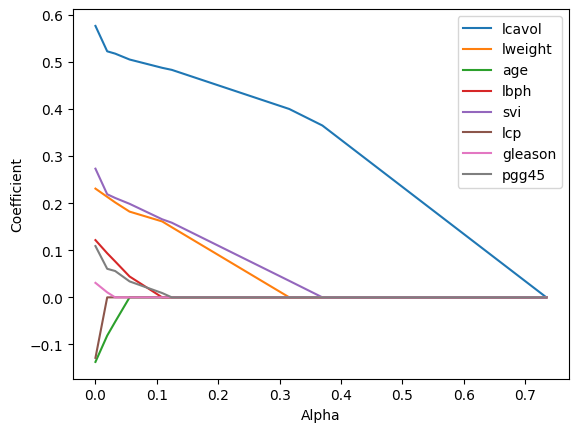

In [8]:
plt.plot(mod_lars.alphas_, mod_lars.coef_path_.T)
plt.legend(df.columns[0:8])
plt.xlabel('Alpha')
plt.ylabel('Coefficient')
plt.show()

Order in which the variables are included in the model:

In [9]:
np.argsort(np.array([np.where(np.concatenate((mod_lars.coef_path_.T, np.ones((8,1)).T)).T[i,:] != 0)[0][0] for i in range(8)]))

array([0, 4, 1, 7, 3, 2, 6, 5])

### b)

In [10]:
mod_lars.alphas_[0]

0.7344603262136727

In [13]:
np.corrcoef(X[:, 0], Y)[0, 1]

0.7344603262136733

### b1)

In [15]:
selected_variables = []

In [16]:
for i in range(8):
    if np.corrcoef(X[:, i], Y)[0, 1] == np.max([np.corrcoef(X[:, j], Y)[0, 1] for j in range(8)]):
        selected_variables.append(i)

In [17]:
selected_variables

[0]

### b2)

In [18]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:, selected_variables], Y)
mod1.coef_

array([0.73446033])

### b3)

In [22]:
# code
y_hat = mod1.predict(X[:, selected_variables])
alphas = np.linspace(0, 1, 100)
corrs = []

for alpha in alphas:
    r1_alpha = Y - alpha * y_hat
    corr = [np.corrcoef(r1_alpha, X[:, i])[0, 1] for i in range(X.shape[1])]
    corrs.append(corr)

corrs = np.array(corrs)

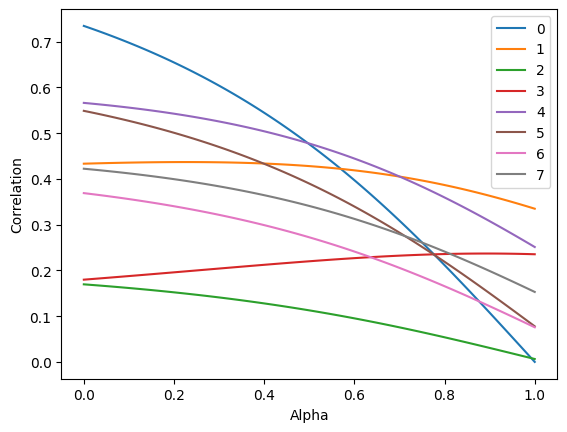

In [24]:
# plot
plt.figure()
for i in range(X.shape[1]):
    plt.plot(alphas, corrs[:, i], label=i)
plt.xlabel('Alpha')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### b4)

In [27]:
r1_alpha = Y - 0.5 * y_hat

np.corrcoef(r1_alpha, X[:, 0])[0, 1], np.corrcoef(r1_alpha, X[:, 4])[0, 1] 

(0.4759095723474517, 0.47734537579687375)

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [28]:
# code
alphas = np.linspace(0, 1, 100)
l = []
for alpha in alphas:
    std_Y = Y.std()
    std_Y_hat = y_hat.std()
    diff = [std_Y * np.corrcoef(Y, X[:, i])[0, 1] - std_Y_hat * alpha * np.corrcoef(y_hat, X[:, i])[0, 1] for i in range(X.shape[1])]
    l.append(diff)
l = np.array(l)

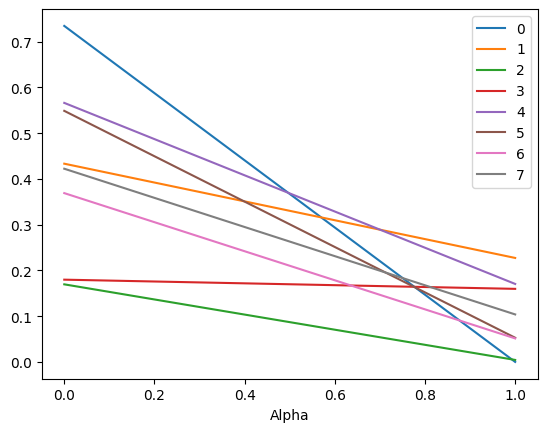

In [30]:
# plot
plt.figure()
for i in range(X.shape[1]):
    plt.plot(alphas, l[:, i], label=i)
plt.xlabel('Alpha')
plt.legend()
plt.show()

In [32]:
nominator = std_Y * np.corrcoef(Y, X[:, 0])[0, 1] - std_Y * np.corrcoef(Y, X[:, 4])[0, 1]
denominator = std_Y_hat * np.corrcoef(y_hat, X[:, 0])[0, 1] - std_Y_hat * np.corrcoef(y_hat, X[:, 4])[0, 1]
alpha2tilda = nominator / denominator
alpha2tilda

0.4967289013871947

### b6)

In [36]:
r1_alpha2 = Y - alpha2tilda * y_hat
alpha2 = std_Y * np.corrcoef(Y, X[:, 4])[0, 1] - alpha2tilda * std_Y_hat * np.corrcoef(y_hat, X[:, 4])[0, 1]
selected_variables = [0, 4]
alpha2

0.3696326552610747

In [35]:
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

### b7)

In [44]:
mod2 = LinearRegression(fit_intercept=False)
mod2.fit(X[:, selected_variables], r1_alpha2)
mod2.coef_

array([0.24020136, 0.24020136])

In [45]:
y_hat = mod2.predict(X[:, selected_variables])

### b8)

In [46]:
alphas = np.linspace(0, 1, 100)
corrs = []
for alpha in alphas:
    r2_alpha = r1_alpha2 - alpha * y_hat
    corr = [np.corrcoef(r2_alpha, X[:, i])[0, 1] for i in range(X.shape[1])]
    corrs.append(corr)
correlations = np.array(corrs)

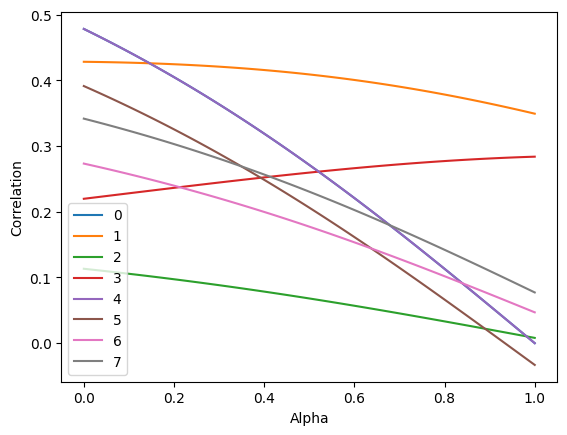

In [47]:
plt.figure()
for i in range(X.shape[1]):
    plt.plot(alphas, correlations[:, i], label=i)
plt.xlabel('Alpha')
plt.ylabel('Correlation')
plt.legend()
plt.show()

### b9)

### b10)

In [48]:
nominator = r1_alpha2.std() * np.corrcoef(r1_alpha2, X[:, 0])[0, 1] - r1_alpha2.std() * np.corrcoef(r1_alpha2, X[:, 1])[0, 1]
denominator =  y_hat.std() * np.corrcoef(y_hat, X[:, 0])[0, 1] - y_hat.std() * np.corrcoef(y_hat, X[:, 1])[0, 1]
alpha3tilda = nominator / denominator
alpha3tilda

0.14590879649354652

### b11)

In [50]:
r1_alpha3 = r1_alpha2 - alpha3tilda * y_hat
alpha_3 = r1_alpha2.std() * np.corrcoef(r1_alpha2, X[:, 1])[0, 1] - alpha3tilda * y_hat.std() * np.corrcoef(y_hat, X[:, 1])[0, 1]
selected_variables = [0, 4, 1]
alpha_3

0.3156999993872172

In [51]:
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

### c)

## Task 2

In [ ]:
X = pd.read_table("data/SRBCT_X.txt", sep=" ")
Y = pd.read_table("data/SRBCT_Y.txt", sep=" ")

X = np.array(X)
Y = np.array(Y)[:,0]

In [ ]:
X = scale(X)
Y = Y - np.mean(Y)

### a)

In [ ]:
mod_lars = Lars(n_nonzero_coefs=80)
# fit

In [ ]:
# plot

In [ ]:
# the order

### b)

In [ ]:
mod_lassolars = LassoLars(alpha=0.15)
# fit

In [ ]:
# order

In [ ]:
# plot

### c)

In [ ]:
lasso_coef = np.zeros((X.shape[1], mod_lassolars.alphas_.shape[0]))

In [ ]:
for i in range(mod_lassolars.alphas_.shape[0]):
    mod_lasso = Lasso(alpha=mod_lassolars.alphas_[i])
    mod_lasso.fit(X, Y)

    lasso_coef[:,i] = mod_lasso.coef_

In [ ]:
# plot